### Compare ROMS idealized bathymetry and GEBCO along-shore mean

In [63]:
#Packages 
import numpy as np
import cartopy
import glob
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import warnings
import xarray as xr
import os
warnings.filterwarnings("ignore") #turns off annoying warnings
#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])
from matplotlib import ticker
crs = ccrs.LambertConformal(
    central_longitude=-148,
    central_latitude=70.5,
    standard_parallels=(30, 60)  # usually two standard parallels
)

### Open GEBCO bathymetry, which is stored in ```/grd```, or download it
 - https://download.gebco.net/. Just download a netcdf of data limited from ~-152, -140 W to 69, 74 N
 - Need to get the bathymetry contours so we can figure out the approximate location of the shelf break jet

In [64]:
ds = xr.open_dataset('/pscratch/sd/d/dylan617/beaufort_roms/generate_inputs/gebco_2025_n75.0_s68.0_w-154.0_e-138.0.nc')
# Filter out land by looking only at negative values
bathy = ds.elevation.where(ds.elevation<0).where(ds.lon>-153).where(ds.lat<72)
print(bathy.lat.min().values)
print(bathy.lat.max().values)
print(bathy.lon.min().values)
print(bathy.lon.max().values)

68.00208333333333
74.99791666666667
-153.99791666666667
-138.00208333333333


### Plot raw bathymetry 

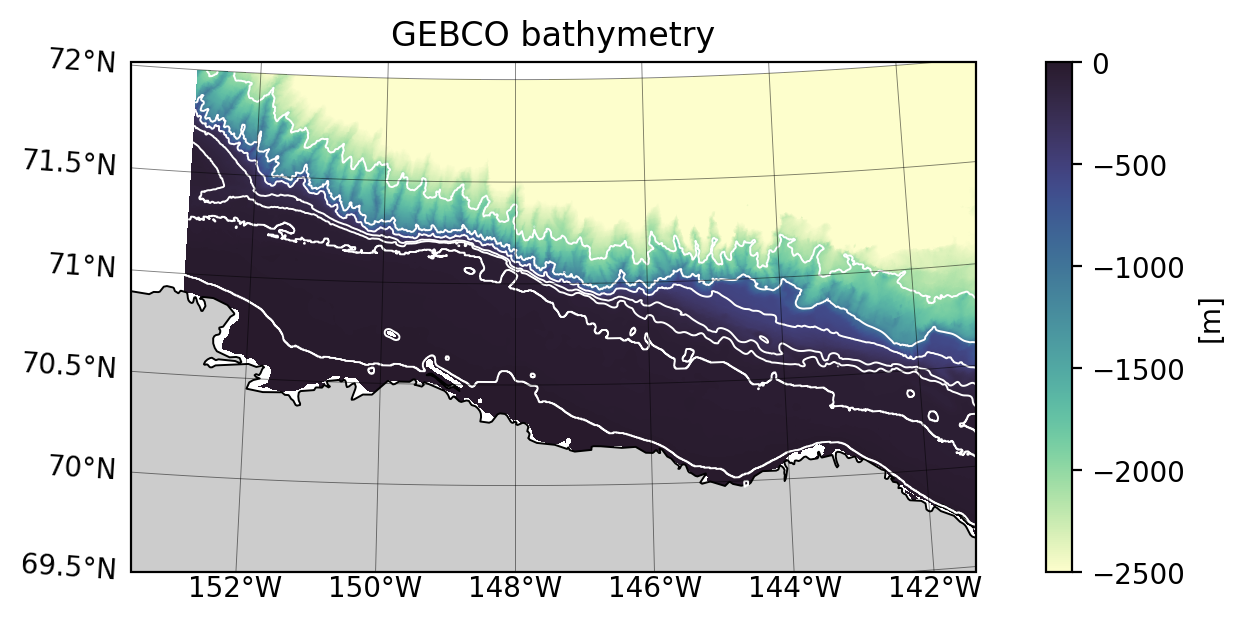

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3), dpi=200,
                       constrained_layout=True, 
                      subplot_kw={'projection': crs})

# Set extent and map features
ax.set_extent([-153.5,-141.4,69.5, 72],ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                            facecolor='0.8'), linewidth=.7)
ax.coastlines(resolution='10m', linewidth=.7)

m = bathy.plot(
    x='lon', y='lat',
    ax=ax,
    cmap=cmo.deep, transform=ccrs.PlateCarree(),
    add_colorbar=False, facecolor="gray",
    vmin = -2500, vmax = 0
)

levs = np.array([-10,-50,-100,-200,-500,-1000,-2000])
bathy.plot.contour(x = 'lon', y = 'lat', levels = levs,
                   colors = 'white', linewidths = 0.7, linestyles = '-',
                   transform=ccrs.PlateCarree())

fig.colorbar(m,ax=ax,label='[m]',pad=0.03)
gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  draw_labels=True, 
                  x_inline=False, y_inline=False, 
                  linewidth=0.33, color='k',alpha=0.5)
gl.right_labels = gl.top_labels = False
gl.xlocator = ticker.FixedLocator([-152, -150,-148,-146,-144,-142])
gl.xlabel_style = {'rotation': 0, 'ha': 'center'}

ax.set_title('GEBCO bathymetry')

fig.canvas.draw()

### Plot alongshore mean

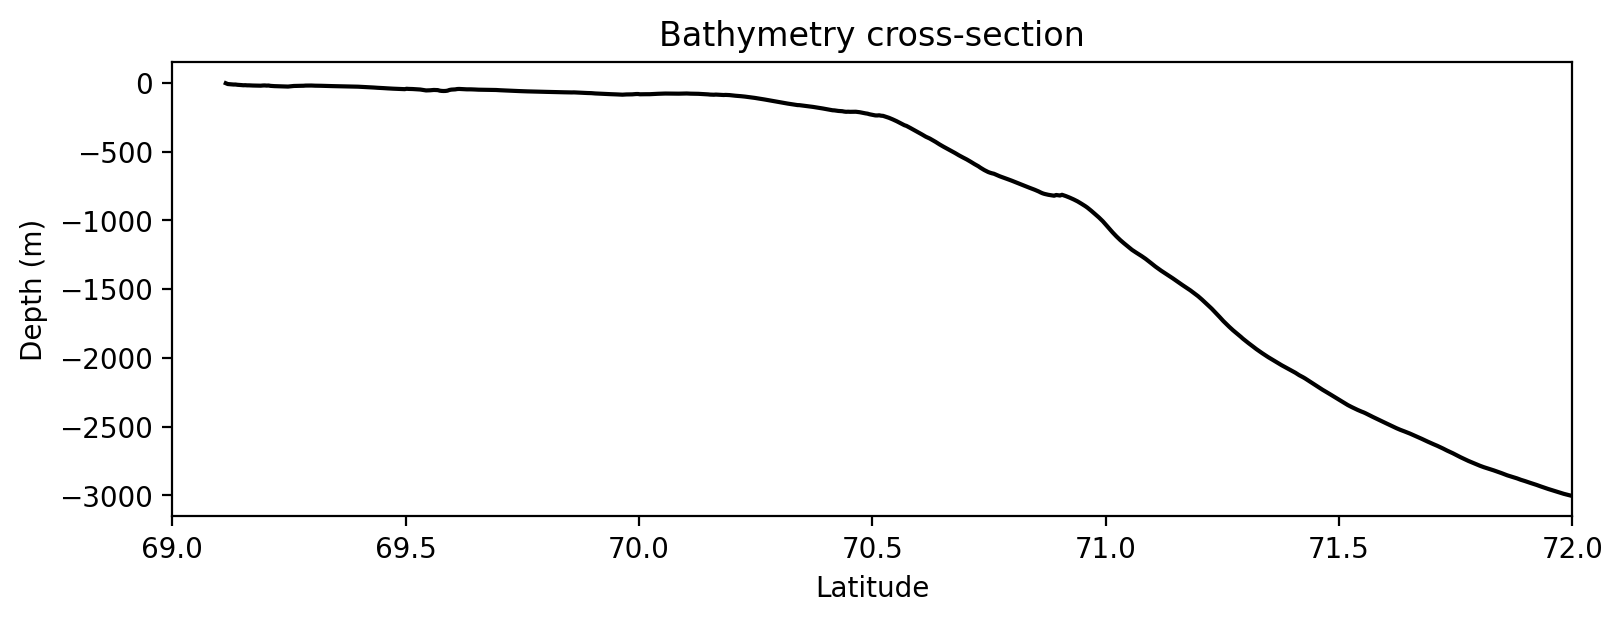

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=200, constrained_layout=True)

# Example: mean bathymetry along longitude
b = bathy.mean('lon')
b.plot(ax=ax, color='k')

# ax.set_facecolor('lightgray')  # optional: background for above sea level
ax.set_xlim(69, 72)
ax.set_title('Bathymetry cross-section')
ax.set_xlabel('Latitude')
ax.set_ylabel('Depth (m)')
plt.show()


In [67]:
# Approximate distance per degree latitude in meters
deg2m_lat = 111_000  

# Cross-shelf slope (north-south)
dz_dy = bathy.differentiate('lat') / deg2m_lat  # slope in m/m

# Select latitudes south of the shelf break (inshore)
inshore_slope = dz_dy.sel(lat=slice(None, 70.2))  # slice from southern edge to 70.2°N

# Average along longitude (along-shelf) and latitude (optional: scalar mean)
mean_inshore_slope_profile = inshore_slope.mean(dim='lon')  # still as a function of latitude
mean_inshore_slope_value = float(mean_inshore_slope_profile.mean())  # single number

print(f"Mean inshore slope (m/m) south of 70.2°N: {mean_inshore_slope_value:.4f}")

lat_south = 69.1
lat_north = 70.2
delta_lat = lat_north - lat_south  # degrees
km_per_deg = 111  # approximate
shelf_length_km = delta_lat * km_per_deg
print(f"Approximate shelf length: {shelf_length_km:.1f} km")


Mean inshore slope (m/m) south of 70.2°N: -0.0022
Approximate shelf length: 122.1 km


In [68]:
# Open ROMS grid, note it has added noise to force instabilities
grd = xr.open_dataset('/pscratch/sd/d/dylan617/beaufort_roms/runs_idealized/inputs/grd.nc')

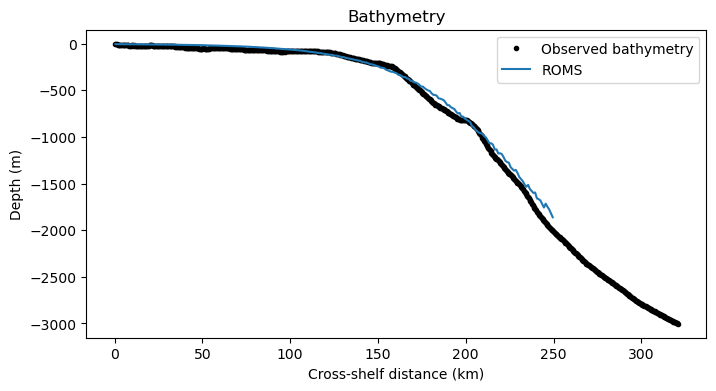

In [69]:
# Remove NaNs so offshore distance isn't skewed by our elevation mask
lat = b['lat']             # coordinates
bath = b                   # bathymetry DataArray
valid = bath.notnull()     # only where bathymetry exists

# convert lat to km
km = lat * km_per_deg
km0 = km[valid][0]         # first VALID km position

# create x
x = xr.full_like(lat, np.nan)
x[valid] = km[valid] - km0

### Zoom out
plt.figure(figsize=(8,4))
plt.plot(x[valid], bath[valid], 'k.', label='Observed bathymetry')
plt.plot(grd.y_rho[:,0]/1000, -grd.h[:,0], label='ROMS')
plt.xlabel('Cross-shelf distance (km)')
plt.ylabel('Depth (m)')
plt.title('Bathymetry')
plt.legend()
plt.show()

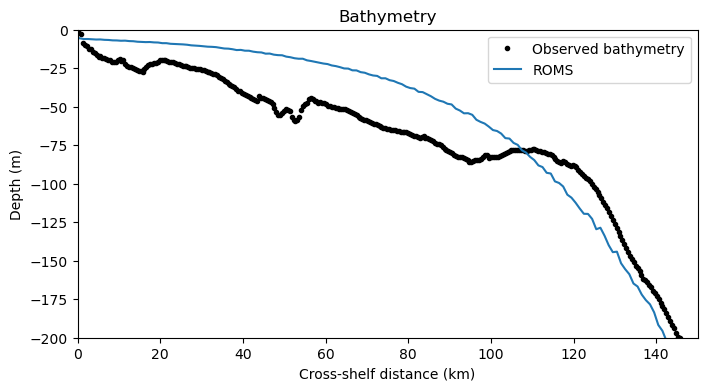

In [70]:
### Zoom in
plt.figure(figsize=(8,4))
plt.plot(x[valid], bath[valid], 'k.', label='Observed bathymetry')
plt.plot(grd.y_rho[:,0]/1000, -grd.h[:,0], label='ROMS')
plt.xlabel('Cross-shelf distance (km)')
plt.ylabel('Depth (m)')
plt.title('Bathymetry')
plt.xlim(0,150)
plt.ylim(-200,0)
plt.legend()
plt.show()

### This is ok, but could be improved